Program for Parameter transfer and Layer selective optimization in ideal and Noisy Quantum device

In [365]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import minimize

from qiskit_aer.noise import (
    NoiseModel,
    amplitude_damping_error,  # for T1 error
    phase_damping_error,  # for T2 error
    depolarizing_error,  # for Gate error
    thermal_relaxation_error  # for T1 + T2 error combined
)

from qiskit_aer import AerSimulator
from qiskit_optimization.applications import Maxcut
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator 
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit import transpile


Donor Graph, which will be fully optimized then these optimum parameters will work as the initial parameters for the acceptor graph

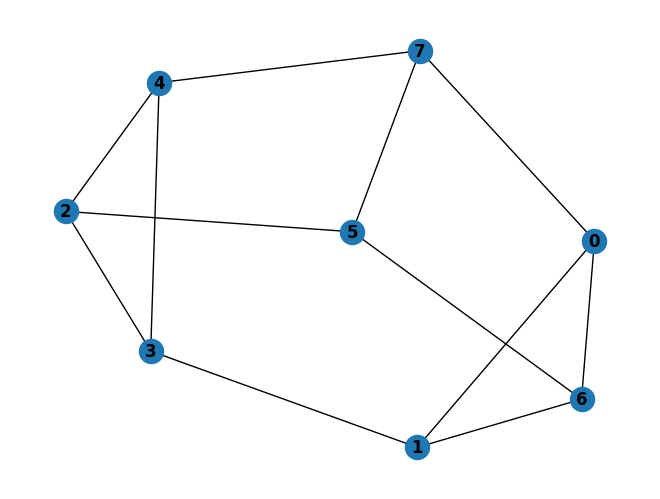

In [366]:
# make sure dxn is even for d-regular graph.
n = 8  # number of vertices
d = 3  #  d-regular graph
p = 5  # QAOA layers

# udR (unweghted d-regular) graph
G = nx.random_regular_graph(d ,n)
for (u,v) in G.edges():
    G[u][v]['weight'] = 1.0

edges = G.edges()
nx.draw(G, with_labels=True, font_weight='bold')

# weight matrix
w = np.zeros([n,n])
for (u,v) in G.edges():
    w[u][v] = G[u][v]['weight']
    w[v][u] = G[u][v]['weight']
#print(w)

Classical solution, $C_{max}$ of donor graph

In [367]:
# classical solution
sol1 = 0
for b in range(2**n):
    x1 = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    Cut_value1 = 0
    for i in range(n):
        for j in range(n):
            Cut_value1 += w[i][j]*x1[i]*(1-x1[j])
    if sol1 < Cut_value1:
        sol1 = Cut_value1
        xlist1 = x1

print(f"Classical solution: {sol1}")

Classical solution: 10.0


Converting the problem into cost hamiltonian $H_C$

In [368]:
prob=Maxcut(w)
qp = prob.to_quadratic_program()
print(qp.prettyprint())
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
print(qubo.prettyprint())

cost_hamiltonian, offset = qubo.to_ising()
print("offset :",offset)
print(cost_hamiltonian)

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_6 - 2*x_0*x_7 - 2*x_1*x_3 - 2*x_1*x_6 - 2*x_2*x_3
  - 2*x_2*x_4 - 2*x_2*x_5 - 2*x_3*x_4 - 2*x_4*x_7 - 2*x_5*x_6 - 2*x_5*x_7
  + 3*x_0 + 3*x_1 + 3*x_2 + 3*x_3 + 3*x_4 + 3*x_5 + 3*x_6 + 3*x_7

Subject to
  No constraints

  Binary variables (8)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7

Problem name: Max-cut

Minimize
  2*x_0*x_1 + 2*x_0*x_6 + 2*x_0*x_7 + 2*x_1*x_3 + 2*x_1*x_6 + 2*x_2*x_3
  + 2*x_2*x_4 + 2*x_2*x_5 + 2*x_3*x_4 + 2*x_4*x_7 + 2*x_5*x_6 + 2*x_5*x_7
  - 3*x_0 - 3*x_1 - 3*x_2 - 3*x_3 - 3*x_4 - 3*x_5 - 3*x_6 - 3*x_7

Subject to
  No constraints

  Binary variables (8)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7

offset : -6.0
SparsePauliOp(['IIIIIIZZ', 'IZIIIIIZ', 'ZIIIIIIZ', 'IIIIZIZI', 'IZIIIIZI', 'IIIIZZII', 'IIIZIZII', 'IIZIIZII', 'IIIZZIII', 'ZIIZIIII', 'IZZIIIII', 'ZIZIIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


Function to calculate the full optimization cost value. This cost value will be offset from the actual cost. So add the offset value at the end to find the actual cost

In [369]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    return cost

Initializing parameters for donor graph using TQA initialization

In [370]:
# Initializing the parameters for our quanutum circuit 
# using Trotterized Quantum Annealing Initialization method.
init_params = np.zeros(2*p)
tt = 0.75
for i in range(0, p, 1):
    init_params[i] = (1.0-i/p)*tt
    init_params[i+p] = (i/p)*tt

# Preparing circuit
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
circuit.measure_all()

Full optimization of donor graph

In [371]:
#--------------------------------------------------------------------------------
# Ideal Case
sim_ideal = AerSimulator()
pm5 = generate_preset_pass_manager(optimization_level=3,backend=sim_ideal)
candidate_circuit5 = pm5.run(circuit)

with Session(backend=sim_ideal) as session:  
    estimator = Estimator(mode=session)  
    estimator.options.default_shots = 100000  
    result5 = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit5, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-3,
    )
ideal_cost = result5.fun+offset  # adding offset to get the true expectation value (energy)
print('ideal cost :',-ideal_cost/sol1)


ideal cost : 0.9185478145218549


Transfering parameters of donor graph

In [372]:
tra_params = result5.x
print(tra_params)

[ 2.14450559  0.41215889  1.44169974  1.39121272  1.41434213  0.41087307
 -0.07528519  0.7067695   0.46835762  1.50555332]


Function to calculate the selective optmization cost

In [373]:
def cost_func_estimator_selective(params, ansatz, hamiltonian, estimator, m):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    sel_par = tra_params.copy()
    sel_par[m] = params[0]
    sel_par[p+m] = params[1]
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, sel_par)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    return cost

Errors in the ${\bf IBMQX4}$

In [374]:
# Coherence times (in nanoseconds)
T1 = 6*45e3  # relaxation time (amplitude damping error)
T2 = 7*20e3  # dephasing time (phase damping error)

# Time taken by different gates
u1 = 0.0  # RZ(gamma) gate (Virtual gate) 
u2 = 60  # Hadamard Gate
u3 = 120  # RX(beta) gate
cx = 720  # CNOT gate (2-qubit gate)

# gate error probability (Depolarizing Error)
err_1q = 0.25*1.5e-3  # 1-qubit gate error
err_2q = 0.25*4e-2  # 2-qubit gate error

Acceptor Graph

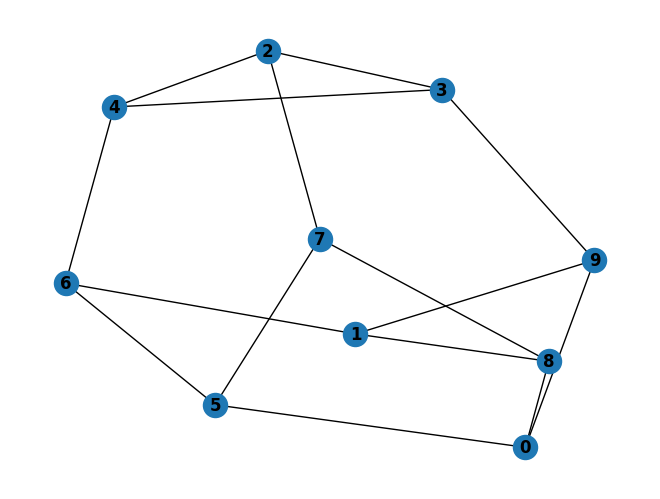

In [375]:
# make sure dxn is even for d-regular graph.
n = 10  # number of vertices

# udR (unweghted d-regular) graph
G = nx.random_regular_graph(d ,n)
for (u,v) in G.edges():
    G[u][v]['weight'] = 1.0

edges = G.edges()
nx.draw(G, with_labels=True, font_weight='bold')

# weight matrix
w = np.zeros([n,n])
for (u,v) in G.edges():
    w[u][v] = G[u][v]['weight']
    w[v][u] = G[u][v]['weight']
#print(w)



Classical Solution of the acceptor graph

In [376]:
# classical solution
sol2 = 0
for b in range(2**n):
    x1 = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    Cut_value1 = 0
    for i in range(n):
        for j in range(n):
            Cut_value1 += w[i][j]*x1[i]*(1-x1[j])
    if sol2 < Cut_value1:
        sol2 = Cut_value1
        xlist1 = x1

print(f"Classical solution: {sol2}")

Classical solution: 13.0


In [377]:
prob1=Maxcut(w)
qp1 = prob1.to_quadratic_program()
qp2qubo1 = QuadraticProgramToQubo()
qubo1 = qp2qubo1.convert(qp1)
cost_hamiltonian1, offset1 = qubo1.to_ising()


Selective optimization after parameter transfer in ideal case

In [382]:
print('Selective optimization in Ideal Case Solution Quality H_C/C_max')
for jj in range(1, p+1, 1):
    with Session(backend=sim_ideal) as session:  
        estimator = Estimator(mode=session)  
        estimator.options.default_shots = 100000  
        opt_par = [tra_params[jj-1], tra_params[p+jj-1]]
        result4 = minimize(
            cost_func_estimator_selective,
            tra_params,
            args=(candidate_circuit5, cost_hamiltonian, estimator, jj-1),
            method="COBYLA",
            tol=1e-3,
        )
    all_cost = result4.fun+offset
    print(f'layer {jj}: ',-all_cost/sol1)
    

Selective optimization in Ideal Case Solution Quality H_C/C_max
layer 1:  0.9195608043919561
layer 2:  0.9192308076919231
layer 3:  0.919449805501945
layer 4:  0.9203317966820332
layer 5:  0.8920460795392046


Creating a noise model to implement the noises in the quantum circuit

In [379]:
total_execution_time = (p*(len(edges)*cx*2+ n*u3)+n*u2)                    
t = total_execution_time

# T1 error
p_t1 = 1 - np.exp(-t / T1)  # amplitude damping error probability
error_t1 = amplitude_damping_error(p_t1)  # 1-qubit T1 error
error_t1_cx = amplitude_damping_error(p_t1).tensor(amplitude_damping_error(p_t1))  # 2-qubit T1 error

# T2 error
p_t2 = 1 - np.exp(-t / T2)  # phase damping error probability
error_t2 = phase_damping_error(p_t2)  # 1-qubit T2 error
error_t2_cx = phase_damping_error(p_t2).tensor(phase_damping_error(p_t2))  # 2-qubit T2 error

# gate error
error_1q = depolarizing_error(err_1q, num_qubits=1)  # 1-qubit gate error
error_2q = depolarizing_error(err_2q, num_qubits=2)  # 2-qubit gate error

error_1q_all = error_t1.compose(error_t2).compose(error_1q)  # combining all 1-qubit errors
error_2q_all = error_t1_cx.compose(error_t2_cx).compose(error_2q)  # combining all 2-qubit errors

# Noise Model
noise_all = NoiseModel()
noise_all.add_all_qubit_quantum_error(error_1q_all, ['u1', 'u2', 'u3'])  # 1-qubit error qate specifications
noise_all.add_all_qubit_quantum_error(error_2q_all, ['cx'])  # 2-qubit error gate specifications


circuit = QAOAAnsatz(cost_operator=cost_hamiltonian1, reps=p)
circuit.measure_all()# Creating the circuit by using Noisy gates as defined by the Noise Model
sim_all = AerSimulator(noise_model = noise_all)
pm1 = generate_preset_pass_manager(optimization_level=3,backend=sim_all)
candidate_circuit1 = pm1.run(circuit)


Full optimization in Noisy case

In [384]:
with Session(backend=sim_all) as session:  
    estimator = Estimator(mode=session)  
    estimator.options.default_shots = 100000  
    result5 = minimize(
        cost_func_estimator,
        tra_params,
        args=(candidate_circuit1, cost_hamiltonian1, estimator),
        method="COBYLA",
        tol=1e-3,
    )
sol = result5.fun+offset1
print("Noisy Full optimization solution quality: ",-sol/sol2)

Noisy Full optimization solution quality:  0.5731927296111654


Selective optimization in noisy case

In [383]:
print('Selective optimization solution quality in noisy case')

for jj in range(1, p+1, 1):
    with Session(backend=sim_all) as session:  
        estimator = Estimator(mode=session)  
        estimator.options.default_shots = 100000  
        opt_par = [tra_params[jj-1], tra_params[p+jj-1]]
        result4 = minimize(
            cost_func_estimator_selective,
            tra_params,
            args=(candidate_circuit1, cost_hamiltonian1, estimator, jj-1),
            method="COBYLA",
            tol=1e-3,
        )
    all_cost = result4.fun+offset1
    print(f'Layer {jj}:',-all_cost/sol2)
    

Selective optimization solution quality in noisy case
Layer 1: 0.5568936618326125
Layer 2: 0.5563959745017935
Layer 3: 0.5565636651325795
Layer 4: 0.5573744262557374
Layer 5: 0.5752565551267564
